In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google'

Get Data as provided

In [ ]:
!pip install folktables

In [2]:
import folktables
from folktables import ACSDataSource
import numpy as np
#(Age) must be greater than 16 and less than 90, and (Person weight) must be greater than or equal to 1
def employment_filter(data):

#Filters for the employment prediction task

    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df

ACSEmployment = folktables.BasicProblem(
    features=[
    'AGEP', #age; for range of values of features please check Appendix B.4 of Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
    'SCHL', #educational attainment
    'MAR', #marital status
    'RELP', #relationship
    'DIS', #disability recode
    'ESP', #employment status of parents
    'CIT', #citizenship status
    'MIG', #mobility status (lived here 1 year ago)
    'MIL', #military service
    'ANC', #ancestry recode
    'NATIVITY', #nativity
    'DEAR', #hearing difficulty
    'DEYE', #vision difficulty
    'DREM', #cognitive difficulty
    'SEX', #sex
    'RAC1P', #recoded detailed race code
    'GCL', #grandparents living with grandchildren
    ],
    target='ESR', #employment status recode
    target_transform=lambda x: x == 1,
    group='DIS',
    preprocess=employment_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["FL"], download=True) #data for Florida state
features, label, group = ACSEmployment.df_to_numpy(acs_data)

In [3]:
features

array([[64., 16.,  1., ...,  1.,  8.,  2.],
       [20., 16.,  5., ...,  1.,  9.,  0.],
       [18., 16.,  5., ...,  1.,  2.,  0.],
       ...,
       [57., 21.,  1., ...,  1.,  1.,  2.],
       [38., 16.,  1., ...,  2.,  9.,  2.],
       [50., 16.,  1., ...,  1.,  2.,  2.]])

In [4]:
!pip install aif360[LawSchoolGPA]

zsh:1: no matches found: aif360[LawSchoolGPA]


In [5]:
from aif360.datasets import StandardDataset
import pandas as pd
data = pd.DataFrame(features, columns = ACSEmployment.features)
data['label'] = label
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])
data_for_aif = StandardDataset(data, 'label', favorable_classes = favorable_classes, protected_attribute_names = protected_attribute_names, privileged_classes = privileged_classes)
privileged_groups = [{'DIS': 1}]
unprivileged_groups = [{'DIS': 2}]

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

In [6]:
data_for_aif

               instance weights features                                       \
                                                          protected attribute   
                                    AGEP  SCHL  MAR  RELP                 DIS   
instance names                                                                  
0                           1.0     64.0  16.0  1.0  16.0                 2.0   
1                           1.0     20.0  16.0  5.0  17.0                 2.0   
2                           1.0     18.0  16.0  5.0  17.0                 2.0   
3                           1.0     72.0   1.0  5.0  17.0                 1.0   
4                           1.0     37.0  17.0  5.0  16.0                 2.0   
...                         ...      ...   ...  ...   ...                 ...   
167301                      1.0     72.0  19.0  2.0   0.0                 2.0   
167302                      1.0     58.0  19.0  1.0   0.0                 1.0   
167303                      

**Task1**
(a)

In [7]:
from sklearn.model_selection import train_test_split
from aif360.datasets import StandardDataset

# Initial train-test split (0.7/0.3)
dataset_train, dataset_test = data_for_aif.split([0.7], shuffle=True, seed=0)
#dataset_train = data_for_aif # For More research 2, use the whole as training but use the TX as test
train_train_splits = []
train_val_splits = []

for i in range(5):
    # Further split the train set into train-train/train-val (0.8/0.2)
    dataset_train_train, dataset_train_val = dataset_train.split([0.8], shuffle=True, seed = i)

    train_train_splits.append(dataset_train_train)
    train_val_splits.append(dataset_train_val)

In [8]:
train_train_splits[0]

               instance weights features                                       \
                                                          protected attribute   
                                    AGEP  SCHL  MAR  RELP                 DIS   
instance names                                                                  
2276                        1.0     19.0  19.0  5.0  17.0                 2.0   
127364                      1.0     44.0  14.0  1.0   0.0                 2.0   
57840                       1.0     63.0  22.0  1.0   6.0                 2.0   
142880                      1.0     69.0  18.0  1.0   1.0                 1.0   
57075                       1.0     69.0  19.0  1.0   0.0                 2.0   
...                         ...      ...   ...  ...   ...                 ...   
132062                      1.0     78.0  16.0  1.0   0.0                 1.0   
101485                      1.0     69.0  16.0  1.0   0.0                 2.0   
123368                      

In [9]:
!pip install 'aif360[Reductions]'

**Task1**(b.c) Use LR as model and use metrics.equal_opportunity_difference as fairness metrics as required

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from aif360.sklearn.metrics import equal_opportunity_difference
from aif360.metrics import ClassificationMetric

# Specify the hyperparameter grid for regularization (C)
param_values = [0.001, 0.01, 0.05, 0.1,0.5, 1, 10]

accuracy_scores = []
equal_opportunity_diffs = []
lr_models = []


for i in range(5):
    for param_value in param_values:

        lr_model = LogisticRegression(solver='liblinear', random_state=42)

        scale_orig = StandardScaler()
        X_train_fold = scale_orig.fit_transform(train_train_splits[i].features)
        y_train_fold = train_train_splits[i].labels.ravel()

        X_val_fold = scale_orig.fit_transform(train_val_splits[i].features)
        y_val_fold = train_val_splits[i]

        # Fit the model on the training fold
        lr_model.fit(X_train_fold, y_train_fold)
        lr_models.append(lr_model)

        # Extract results
        y_val_prob = lr_model.predict(X_val_fold)

        accuracy = accuracy_score(train_val_splits[i].labels.ravel(), y_val_prob)
        accuracy_scores.append(accuracy)

        y_val_pred = y_val_fold.copy()
        y_val_pred.labels = y_val_prob

        eod = ClassificationMetric(y_val_fold, y_val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups).equal_opportunity_difference()
        equal_opportunity_diffs.append(eod)



pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


In [11]:
max_accuracy_index = np.argmax(accuracy_scores)
min_eod_index = np.argmin(np.abs(equal_opportunity_diffs))

best_model_accuracy = lr_models[max_accuracy_index]
best_model_eod = lr_models[min_eod_index]

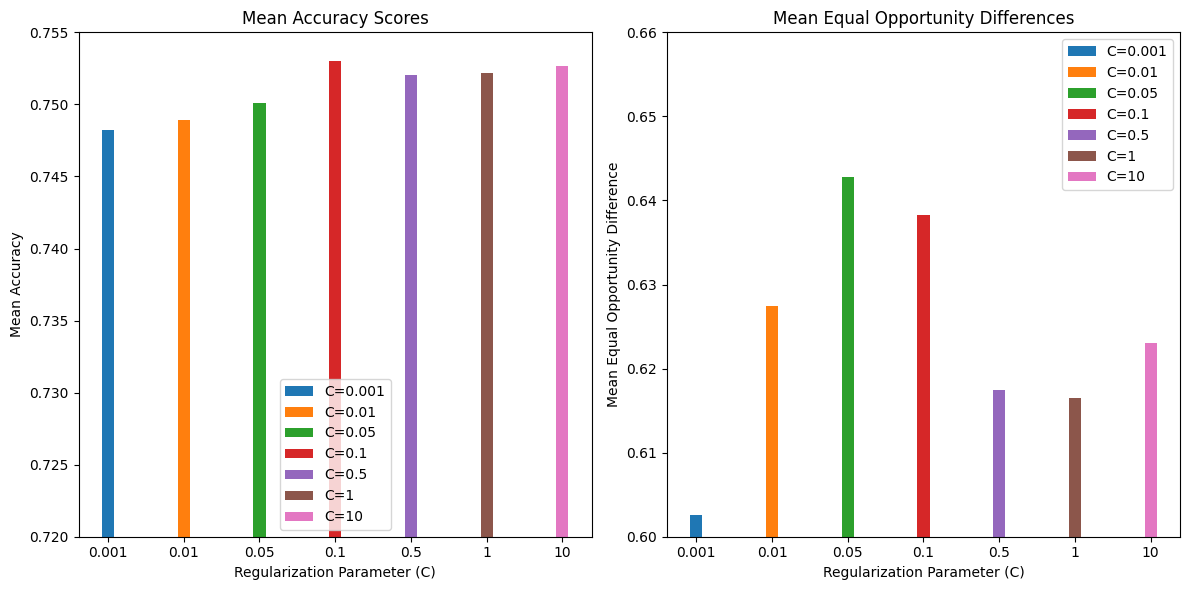

In [13]:

step_size = 5
accuracy_scores_grouped = np.array([accuracy_scores[i:i+step_size] for i in range(0, len(accuracy_scores), step_size)])
equal_opportunity_diffs_grouped = np.array([equal_opportunity_diffs[i:i+step_size] for i in range(0, len(equal_opportunity_diffs), step_size)])

param_ticks = np.arange(0, len(param_values) * step_size, step_size)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i, param_tick in enumerate(param_ticks):
    plt.bar(param_tick, np.mean(accuracy_scores_grouped[i]), label=f'C={param_values[i]}', width=0.8, align='center')
plt.title('Mean Accuracy Scores')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Mean Accuracy')
plt.xticks(param_ticks, param_values)
plt.ylim(0.72, 0.755)
plt.legend()

plt.subplot(1, 2, 2)
for i, param_tick in enumerate(param_ticks):
    plt.bar(param_tick, np.mean(equal_opportunity_diffs_grouped[i]), label=f'C={param_values[i]}', width=0.8, align='center')
plt.title('Mean Equal Opportunity Differences')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Mean Equal Opportunity Difference')
plt.xticks(param_ticks, param_values)
plt.ylim(0.6, 0.66)
plt.legend()

plt.tight_layout()
# plt.savefig('./task1')


In [14]:
scale_orig = StandardScaler()
X_test = scale_orig.fit_transform(dataset_test.features)
y_test = dataset_test

print("Accuracy based model:")
y_test_pred = best_model_accuracy.predict(X_test)

accuracy = accuracy_score(y_test.labels.ravel(), y_test_pred)
print("Accuracy:", accuracy)

y_pred = y_test.copy()
y_pred.labels = y_test_pred

eod = ClassificationMetric(y_test, y_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups).equal_opportunity_difference()
print("Equal Opportunity Differences:",eod)


print("EOD based model:")
y_test_pred = best_model_eod.predict(X_test)

accuracy = accuracy_score(y_test.labels.ravel(), y_test_pred)
print("Accuracy:", accuracy)

y_pred = y_test.copy()
y_pred.labels = y_test_pred

eod = ClassificationMetric(y_test, y_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups).equal_opportunity_difference()
print("Equal Opportunity Differences:",eod)

Accuracy based model:
Accuracy: 0.7531877590054192
Equal Opportunity Differences: 0.6242599728170969
EOD based model:
Accuracy: 0.752908830092445
Equal Opportunity Differences: 0.620592030050883


**Task2** Use Reweighting in LR

In [12]:
from aif360.algorithms.preprocessing.reweighing import Reweighing

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)


In [172]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from aif360.sklearn.metrics import equal_opportunity_difference
from aif360.metrics import ClassificationMetric

# Specify the hyperparameter grid for regularization (C)
param_values = [0.001, 0.01, 0.05, 0.1,0.5, 1, 10]

accuracy_scores = []
equal_opportunity_diffs = []
lr_models = []


for i in range(5):
    for param_value in param_values:

        train = RW.fit_transform(train_train_splits[i])
        lr_model = LogisticRegression(solver='liblinear', random_state=42)

        scale_orig = StandardScaler()
        X_train_fold = scale_orig.fit_transform(train_train_splits[i].features)
        y_train_fold = train_train_splits[i].labels.ravel()

        X_val_fold = scale_orig.fit_transform(train_val_splits[i].features)
        y_val_fold = train_val_splits[i]

        # Fit the model on the training fold
        lr_model.fit(X_train_fold, y_train_fold, sample_weight=train.instance_weights)
        lr_models.append(lr_model)

        # Extract results
        y_val_prob = lr_model.predict(X_val_fold)

        accuracy = accuracy_score(train_val_splits[i].labels.ravel(), y_val_prob)
        accuracy_scores.append(accuracy)

        y_val_pred = y_val_fold.copy()
        y_val_pred.labels = y_val_prob

        eod = ClassificationMetric(y_val_fold, y_val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups).equal_opportunity_difference()
        equal_opportunity_diffs.append(eod)



In [173]:
max_accuracy_index = np.argmax(accuracy_scores)
min_eod_index = np.argmin(np.abs(equal_opportunity_diffs))

best_model_accuracy = lr_models[max_accuracy_index]
best_model_eod = lr_models[min_eod_index]

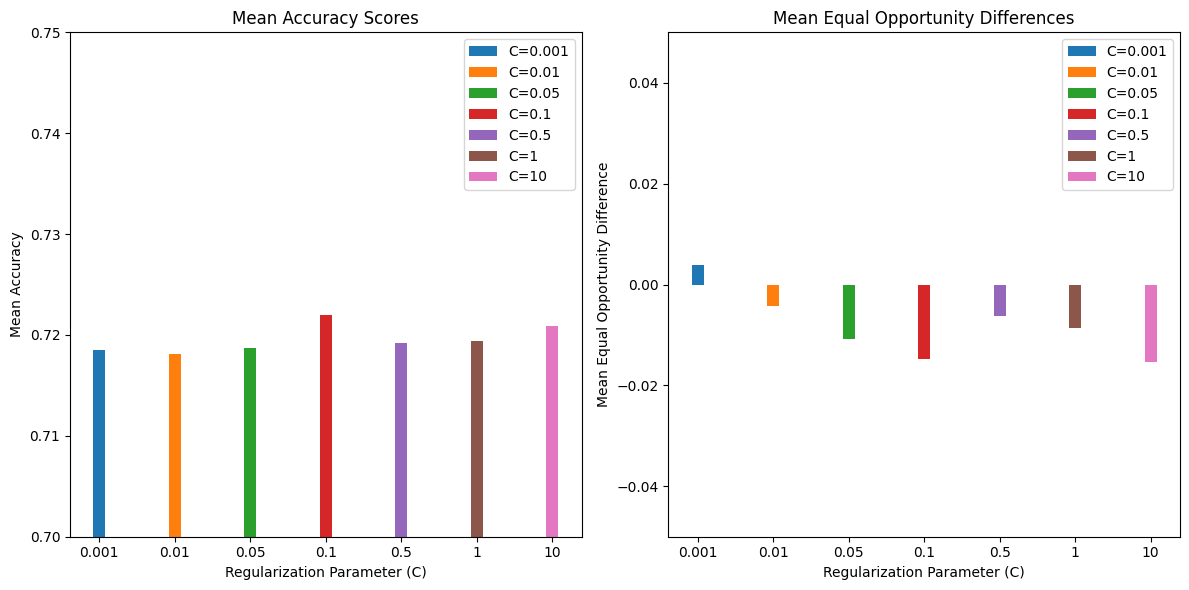

In [176]:

step_size = 5
accuracy_scores_grouped = np.array([accuracy_scores[i:i+step_size] for i in range(0, len(accuracy_scores), step_size)])
equal_opportunity_diffs_grouped = np.array([equal_opportunity_diffs[i:i+step_size] for i in range(0, len(equal_opportunity_diffs), step_size)])

param_ticks = np.arange(0, len(param_values) * step_size, step_size)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i, param_tick in enumerate(param_ticks):
    plt.bar(param_tick, np.mean(accuracy_scores_grouped[i]), label=f'C={param_values[i]}', width=0.8, align='center')
plt.title('Mean Accuracy Scores')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Mean Accuracy')
plt.xticks(param_ticks, param_values)
plt.ylim(0.7, 0.75)
plt.legend()

plt.subplot(1, 2, 2)
for i, param_tick in enumerate(param_ticks):
    plt.bar(param_tick, np.mean(equal_opportunity_diffs_grouped[i]), label=f'C={param_values[i]}', width=0.8, align='center')
plt.title('Mean Equal Opportunity Differences')
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Mean Equal Opportunity Difference')
plt.xticks(param_ticks, param_values)
plt.ylim(-0.05, 0.05)
plt.legend()

plt.tight_layout()
plt.savefig('./task2')


In [177]:
scale_orig = StandardScaler()
X_test = scale_orig.fit_transform(dataset_test.features)
y_test = dataset_test

print("Accuracy based model:")
y_test_pred = best_model_accuracy.predict(X_test)

accuracy = accuracy_score(y_test.labels.ravel(), y_test_pred)
print("Accuracy:", accuracy)

y_pred = y_test.copy()
y_pred.labels = y_test_pred

eod = ClassificationMetric(y_test, y_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups).equal_opportunity_difference()
print("Equal Opportunity Differences:",eod)


print("EOD based model:")
y_test_pred = best_model_eod.predict(X_test)

accuracy = accuracy_score(y_test.labels.ravel(), y_test_pred)
print("Accuracy:", accuracy)

y_pred = y_test.copy()
y_pred.labels = y_test_pred

eod = ClassificationMetric(y_test, y_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups).equal_opportunity_difference()
print("Equal Opportunity Differences:",eod)

Accuracy based model:
Accuracy: 0.6873938125725914
Equal Opportunity Differences: 0.0021091384522455847
EOD based model:
Accuracy: 0.6866786972422465
Equal Opportunity Differences: 0.0019632590828382313


**Task3** Use paper method: A Confidence-Based Approach for Balancing Fairness and Accuracy


In [179]:
# We select param_value = 0.1, and make confidence_threshold as the hyperparameter
param_value = 0.1
accuracy_scores = []
equal_opportunity_diffs = []
lr_models = []

confidence_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for i in range(5):
    for confidence_threshold in confidence_thresholds:

        train = RW.fit_transform(train_train_splits[i])
        lr_model = LogisticRegression(solver='liblinear', random_state=42)

        scale_orig = StandardScaler()
        X_train_fold = scale_orig.fit_transform(train_train_splits[i].features)
        y_train_fold = train_train_splits[i].labels.ravel()

        X_val_fold = scale_orig.fit_transform(train_val_splits[i].features)
        y_val_fold = train_val_splits[i]

        # Fit the model on the training fold
        lr_model.fit(X_train_fold, y_train_fold, sample_weight=train.instance_weights)
        lr_models.append(lr_model)

        # Extract results
        y_val_prob = lr_model.predict_proba(X_val_fold)[:, 1]  # Probability of positive class

        # Adjust decision threshold based on confidence scores
        y_val_pred_1 = (y_val_prob >= confidence_threshold).astype(int)

        # Evaluate accuracy
        accuracy = accuracy_score(train_val_splits[i].labels.ravel(), y_val_pred_1)
        accuracy_scores.append(accuracy)

        y_val_pred = y_val_fold.copy()
        y_val_pred.labels = y_val_pred_1

        eod = ClassificationMetric(y_val_fold, y_val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups).equal_opportunity_difference()
        equal_opportunity_diffs.append(eod)



In [180]:
max_accuracy_index = np.argmax(accuracy_scores)
min_eod_index = np.argmin(np.abs(equal_opportunity_diffs))

best_model_accuracy = lr_models[max_accuracy_index]
best_model_eod = lr_models[min_eod_index]

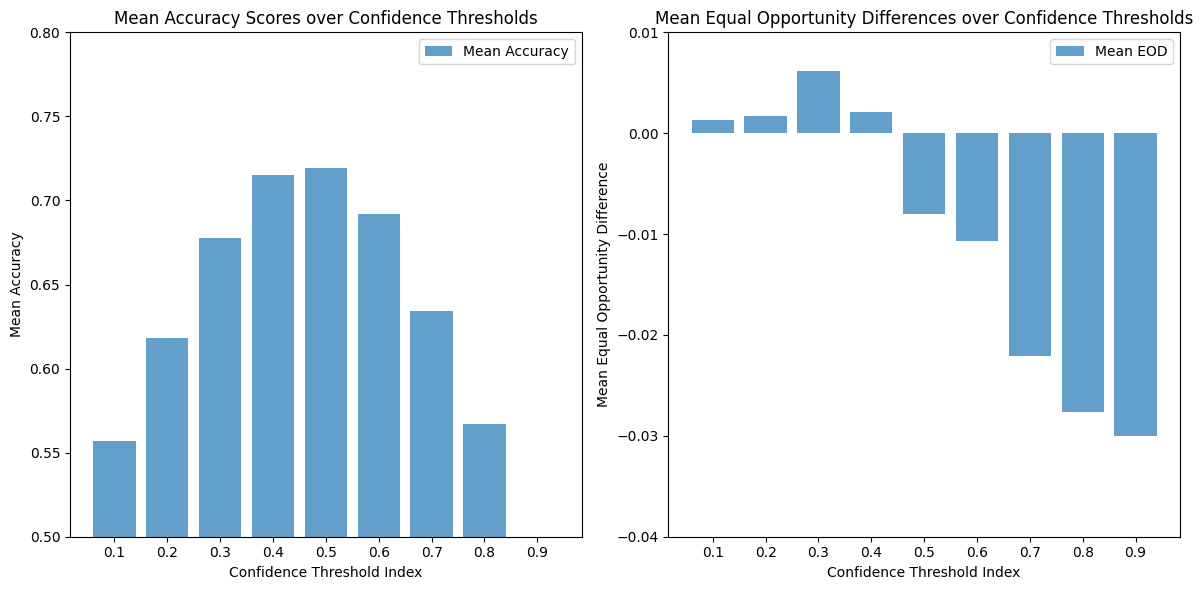

In [185]:
# Group accuracy and EOD scores for plotting
accuracy_scores_grouped = np.array([accuracy_scores[i:i+len(confidence_thresholds)] for i in range(0, len(accuracy_scores), len(confidence_thresholds))])
equal_opportunity_diffs_grouped = np.array([equal_opportunity_diffs[i:i+len(confidence_thresholds)] for i in range(0, len(equal_opportunity_diffs), len(confidence_thresholds))])

# Calculate mean values
mean_accuracy_scores = np.mean(accuracy_scores_grouped, axis=0)
mean_equal_opportunity_diffs = np.mean(equal_opportunity_diffs_grouped, axis=0)

# Plotting
param_ticks = np.arange(len(confidence_thresholds))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(param_ticks, mean_accuracy_scores, width=0.8, align='center', alpha=0.7, label='Mean Accuracy')
plt.title('Mean Accuracy Scores over Confidence Thresholds')
plt.xlabel('Confidence Threshold Index')
plt.ylabel('Mean Accuracy')
plt.xticks(param_ticks, confidence_thresholds)
plt.ylim(0.5, 0.8)
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(param_ticks, mean_equal_opportunity_diffs, width=0.8, align='center',alpha=0.7, label='Mean EOD')
plt.title('Mean Equal Opportunity Differences over Confidence Thresholds')
plt.xlabel('Confidence Threshold Index')
plt.ylabel('Mean Equal Opportunity Difference')
plt.xticks(param_ticks, confidence_thresholds)
plt.ylim(-0.04, 0.01)
plt.legend()

plt.tight_layout()
plt.savefig('./task3.png')
plt.show()


In [186]:
scale_orig = StandardScaler()
X_test = scale_orig.fit_transform(dataset_test.features)
y_test = dataset_test

print("Accuracy based model:")
y_test_pred = best_model_accuracy.predict(X_test)

accuracy = accuracy_score(y_test.labels.ravel(), y_test_pred)
print("Accuracy:", accuracy)

y_pred = y_test.copy()
y_pred.labels = y_test_pred

eod = ClassificationMetric(y_test, y_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups).equal_opportunity_difference()
print("Equal Opportunity Differences:",eod)


print("EOD based model:")
y_test_pred = best_model_eod.predict(X_test)

accuracy = accuracy_score(y_test.labels.ravel(), y_test_pred)
print("Accuracy:", accuracy)

y_pred = y_test.copy()
y_pred.labels = y_test_pred

eod = ClassificationMetric(y_test, y_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups).equal_opportunity_difference()
print("Equal Opportunity Differences:",eod)

Accuracy based model:
Accuracy: 0.6873938125725914
Equal Opportunity Differences: 0.0021091384522455847
EOD based model:
Accuracy: 0.6873938125725914
Equal Opportunity Differences: 0.0021091384522455847


**More research 1**: On remove of DIS in the data set

In [140]:
features, label, group

(array([[64., 16.,  1., ...,  1.,  8.,  2.],
        [20., 16.,  5., ...,  1.,  9.,  0.],
        [18., 16.,  5., ...,  1.,  2.,  0.],
        ...,
        [57., 21.,  1., ...,  1.,  1.,  2.],
        [38., 16.,  1., ...,  2.,  9.,  2.],
        [50., 16.,  1., ...,  1.,  2.,  2.]]),
 array([False, False, False, ..., False, False, False]),
 array([2, 2, 2, ..., 2, 1, 1]))

In [142]:
#split data again
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

test = StandardDataset(data, 'label', favorable_classes = favorable_classes, protected_attribute_names = protected_attribute_names, privileged_classes = privileged_classes)

train_train_splits = []
train_val_splits = []


for i in range(5):
    # Split into train and validation sets (70% train, 30% validation)
    train_train_data, train_val_data= train_test_split(
        train_data, test_size=0.3, random_state=i
    )
    #drop protected features
    train_train_data = StandardDataset(data, 'label', favorable_classes = favorable_classes,protected_attribute_names=[],features_to_drop = 'DIS' , privileged_classes = privileged_classes)
    train_val_data = StandardDataset(data, 'label', favorable_classes = favorable_classes, protected_attribute_names = protected_attribute_names, privileged_classes = privileged_classes)
    # Append the splits to the lists
    train_train_splits.append(train_train_data)
    train_val_splits.append(train_val_data)


In [145]:
dataset_test = test

In [144]:
train_train_splits[0]

               instance weights features                                       \
                                                                                
                                    AGEP  SCHL  MAR  RELP  DIS  ESP  CIT  MIG   
instance names                                                                  
0                           1.0     64.0  16.0  1.0  16.0  2.0  0.0  5.0  3.0   
1                           1.0     20.0  16.0  5.0  17.0  2.0  0.0  1.0  3.0   
2                           1.0     18.0  16.0  5.0  17.0  2.0  0.0  1.0  3.0   
3                           1.0     72.0   1.0  5.0  17.0  1.0  0.0  1.0  1.0   
4                           1.0     37.0  17.0  5.0  16.0  2.0  0.0  1.0  1.0   
...                         ...      ...   ...  ...   ...  ...  ...  ...  ...   
167301                      1.0     72.0  19.0  2.0   0.0  2.0  0.0  1.0  1.0   
167302                      1.0     58.0  19.0  1.0   0.0  1.0  0.0  1.0  3.0   
167303                      

The rest codes are the same above. Just rerun it again.

**More 2: Train on FL but test on TX**

In [162]:
import folktables
from folktables import ACSDataSource
import numpy as np
#(Age) must be greater than 16 and less than 90, and (Person weight) must be greater than or equal to 1
def employment_filter(data):

#Filters for the employment prediction task

    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df

ACSEmployment = folktables.BasicProblem(
    features=[
    'AGEP', #age; for range of values of features please check Appendix B.4 of Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
    'SCHL', #educational attainment
    'MAR', #marital status
    'RELP', #relationship
    'DIS', #disability recode
    'ESP', #employment status of parents
    'CIT', #citizenship status
    'MIG', #mobility status (lived here 1 year ago)
    'MIL', #military service
    'ANC', #ancestry recode
    'NATIVITY', #nativity
    'DEAR', #hearing difficulty
    'DEYE', #vision difficulty
    'DREM', #cognitive difficulty
    'SEX', #sex
    'RAC1P', #recoded detailed race code
    'GCL', #grandparents living with grandchildren
    ],
    target='ESR', #employment status recode
    target_transform=lambda x: x == 1,
    group='DIS',
    preprocess=employment_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["TX"], download=True) #data for Florida state
features, label, group = ACSEmployment.df_to_numpy(acs_data)

from aif360.datasets import StandardDataset
import pandas as pd
data = pd.DataFrame(features, columns = ACSEmployment.features)
data['label'] = label
favorable_classes = [True]
protected_attribute_names = [ACSEmployment.group]
privileged_classes = np.array([[1]])
data_for_aif = StandardDataset(data, 'label', favorable_classes = favorable_classes, protected_attribute_names = protected_attribute_names, privileged_classes = privileged_classes)
privileged_groups = [{'DIS': 1}]
unprivileged_groups = [{'DIS': 2}]

dataset_test = data_for_aif

In [163]:
dataset_test

               instance weights features                                       \
                                                          protected attribute   
                                    AGEP  SCHL  MAR  RELP                 DIS   
instance names                                                                  
0                           1.0     21.0  16.0  5.0  17.0                 2.0   
1                           1.0     19.0  16.0  5.0  17.0                 2.0   
2                           1.0     24.0  12.0  5.0  16.0                 1.0   
3                           1.0     20.0  16.0  5.0  17.0                 2.0   
4                           1.0     31.0  17.0  5.0  17.0                 2.0   
...                         ...      ...   ...  ...   ...                 ...   
208353                      1.0     19.0  19.0  5.0   2.0                 2.0   
208354                      1.0     24.0  19.0  5.0  10.0                 2.0   
208355                      

The rest codes for 1-6 are the same. Refer to the above things.